# Skip-gram Negative Sampling with Tensorflow 

## Resources
* Mikolov et al (2013a) [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf) 
* Mikolov et al (2013b) [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf)
* CS224n Lecture (2018) on [Word Vectors 1](http://web.stanford.edu/class/cs224n/lectures/lecture2.pdf)
* Tensorflow Tutorial [Vector Representations of Words](https://www.tensorflow.org/tutorials/representation/word2vec)
* Word2Vec Tutorial by Chris McCormick (2016): [The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
* Word2Vec Tutorial by Andy Thomas (2017) [Word2Vec word embedding tutorial in Python and TensorFlow](http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/) 
* Word Embeddings Series by Sebastian Ruder (2016-2017) [On word embeddings and a series of excellent posts](http://ruder.io/tag/word-embeddings/)

In [1]:
import tensorflow as tf
import numpy as np

import collections
import random
import os
import sys
import time
import urllib
import zipfile

from datetime import datetime
from tempfile import gettempdir

from tensorboard.plugins import projector

In [2]:
print('Tensorflow', tf.__version__)
print('Python', sys.version)

Tensorflow 1.9.0
Python 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


## Download and read the data from file
Helper functions adapted from [Tensorflow's Github repository](https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

In [3]:
def maybe_download(url, filename, expected_bytes):
    "Download the file if not present, and make sure it's the right size."    
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename, local_filename)
        statinfo = os.stat(local_filename)
        if statinfo.st_size == expected_bytes:
            print('Found and verified', filename)
        else:
            print(statinfo.st_size)
            raise Exception('Failed to verify ' + local_filename + 
                            '. Can you get to it with a browser?')
    return local_filename


def read_data(filename):
    "Extract the file enclosed in a zip file as a list of words (strings)."
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


def normalize_counter(counter):
    "Used to normalize the counts/frequency"
    total = sum(counter.values())
    for w_idx in counter:
        counter[w_idx] /= total
    return counter


def build_dataset(words, n_words):
    "Process raw inputs into a dataset"
    count = collections.Counter(words).most_common(n_words - 1)
    dictionary = {'UNK': 0}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    for word in words:
        index = dictionary.get(word, 0) # words outside of vocab replaced with UNK
        data.append(index)
    count = normalize_counter(collections.Counter(data)).most_common(n_words)
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


### Text8
http://mattmahoney.net/dc/textdata.html

In [4]:
filename = maybe_download(
    url='http://mattmahoney.net/dc/', filename='text8.zip', expected_bytes=31344016)

## Process the data and build the dictionaries

In [5]:
data = read_data(filename)
original_len = len(data)
print('Total number of words in text: {:,}.'.format(original_len))

MAX_VOCAB = 50000    #  train on the most common 50,000 words in the text
"""
data               :  list of IDs(int) representing the original words in text
count              :  maps IDs(int) to normalized count/frequency in text
dictionary         :  maps words(strings) to their IDs(int)
reverse_dictionary :  maps IDs(int) to words(strings)
"""
data, count, dictionary, reverse_dictionary = build_dataset(data, MAX_VOCAB)
print('The 5 most common words (normalized counts):', 
      [(reverse_dictionary[i], c) for i, c in count[:5]])
print('First 10 words in text:', 
      data[:10], [reverse_dictionary[i] for i in data[:10]])

Total number of words in text: 17,005,207.
The 5 most common words (normalized counts): [('the', 0.06241594118789615), ('of', 0.034911483288618594), ('UNK', 0.024603699325741815), ('and', 0.02450008400368193), ('one', 0.02421399516042351)]
First 10 words in text: [5244, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### Calculate frequencies for negative sampling and subsampling of frequent words
Section 2.2 of Mikolov et al (2013b)

In [6]:
def build_unigrams_dist(count):
    'Returns list of normalized frequencies per word in vocab'
    unigrams_dist = [0] * MAX_VOCAB
    for w_idx, count in count:
        unigrams_dist[w_idx] = count
    return unigrams_dist


In [7]:
unigram_dist = build_unigrams_dist(count) # used in negative sampling

### Subsampling of frequent words
Section 2.3 of Mikolov et al (2013b) 

In [8]:
def build_subsampling_dict(count, t=1e-3):
    "Source: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling"
    "Also: https://groups.google.com/d/msg/word2vec-toolkit/pE2qLbgpuys/F8ZQztKIfYUJ"
    return {w_idx: (np.sqrt(f/t) + 1)*(t/f) for w_idx, f in count}


def subsample_words(data, count):
    "Source: https://github.com/chrisjmccormick/word2vec_commented/blob/master/word2vec.c"
    subsampler = build_subsampling_dict(count)
    return [w for w in data 
            if subsampler[w] >= 1 or subsampler[w] >= random.random()]
    

In [9]:
data = subsample_words(data, count)
difference = original_len - len(data)

print('Original text length: {:,} words.'.format(original_len))
print('Subsampled text length: {:,} words.'.format(len(data)))
print('Dropped {:.2f}% words ({:,} words)'.format(difference* 100 / original_len, difference))

Original text length: 17,005,207 words.
Subsampled text length: 12,501,643 words.
Dropped 26.48% words (4,503,564 words)


### Training samples

In [10]:
def generate_windows(batch_size, skip_window):
    'Generates list of different sized windows (the R term in 2013a paper)'
    windows = []
    while sum(windows) < batch_size/2:  # each window generates size x 2 samples
        windows.append(random.randint(1, skip_window)) # randomly sample size
    windows[-1] -= sum(windows) - int(batch_size/2)
    return windows


"""
The original word2vec in C uses SGD without mini-batches.
See: https://groups.google.com/forum/#!topic/word2vec-toolkit/Un_E2eLH9Ek
To increase speed, they use CPU multi-threading instead. 
Here we use mini-batches so the learning rate needs to start higher.
"""
def generate_batch_skipgram(batch_size, skip_window):
    """
    Returns:
    batch: shape=(batch_size,) center words (repeated based on window size)
    labels: shape=(batch_size, 1) context/target words
    data_index: position of last word processed (in the original text)
    """
    batch, labels = [], []
    data_index = skip_window
    while data_index + skip_window < len(data):
        windows = generate_windows(batch_size, skip_window)
        for window in windows:
            span = 2*window + 1
            buffer = data[data_index-window:data_index+window+1]
            context_words = [w for w in range(span) if w != window]
            for context_word in context_words:
                batch.append(buffer[window])
                labels.append(buffer[context_word])
                if len(batch) == batch_size:
                    yield (np.array(batch),
                           np.expand_dims(np.array(labels), 1),
                           data_index)
                    batch, labels = [], []
            data_index += 1
            if data_index + skip_window == len(data): # reached end of text
                break
    if batch and labels:
        yield np.array(batch), np.expand_dims(np.array(labels), 1), data_index


In [11]:
print(data[:6], [reverse_dictionary[i] for i in data[:8]])
batch, labels, data_index = next(generate_batch_skipgram(batch_size=8, skip_window=2))
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], 
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])
print('Position of last word processed:', data_index)

[5244, 3081, 195, 3134, 46, 59] ['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'against', 'early']
195 term -> 3081 originated
195 term -> 3134 abuse
3134 abuse -> 3081 originated
3134 abuse -> 195 term
3134 abuse -> 46 first
3134 abuse -> 59 used
46 first -> 3134 abuse
46 first -> 59 used
Position of last word processed: 4


## Set the hyperparameter values

* Code commented by Chris McCormick (2016) [word2vec_commented](https://github.com/chrisjmccormick/word2vec_commented/blob/master/word2vec.c)
* Further reading: Caselles-Dupré et al (2018) [Word2vec applied to Recommendation: Hyperparameters Matter](https://arxiv.org/pdf/1804.04212)

In [12]:
batch_size = 256       # number of training samples to process in parallel
start_lr = 1.0         # initial Learning rate (1.0 seems to perform well)
min_lr = 1e-3          # minimum learning rate
skip_window = 10       # max number of words to consider each side of center word
embedding_size = 200   # dimension of the embedding vector.
k_negative = 20        # number of negative samples per correct sample.
                       # see https://github.com/tensorflow/tensorflow/issues/17949
ns_exp = 0.75          # exponent to shape the negative sampling distribution

## Select validation set for monitoring training progress 

In [13]:
valid_size = 16       # random set of words to evaluate training progress
valid_window = 100    # pick from most common 100 words to observe progress

In [14]:
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

## Building the Tensorflow Graph 

In [15]:
graph = tf.Graph()
with graph.as_default(): 
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[None])
        train_labels = tf.placeholder(tf.int64, shape=[None, 1])
        valid_dataset = tf.constant(valid_examples, tf.int32)
    
    with tf.name_scope('embeddings'):
        embeddings = tf.get_variable('embed_matrix', shape=(MAX_VOCAB, embedding_size), 
                                     initializer=tf.random_uniform_initializer(-1.0, 1.0))
        embedded_inputs = tf.nn.embedding_lookup(embeddings, train_inputs)
        
    with tf.name_scope('weights'):
        softmax_w = tf.get_variable('softmax_w', shape=(MAX_VOCAB, embedding_size),
                                    initializer=tf.truncated_normal_initializer(
                                        stddev=1.0/embedding_size**0.5))
        softmax_b = tf.get_variable('softmax_b', shape=(MAX_VOCAB),
                                    initializer=tf.zeros_initializer())
    
    # Tensorflow implementation of negative sampling.
    # Construct a candidate sampler and use it with a sampled loss function.
    # See https://www.tensorflow.org/api_guides/python/nn#Candidate_Sampling
    with tf.name_scope('loss'):
        sampler = tf.nn.fixed_unigram_candidate_sampler(true_classes=train_labels,
                                                        num_true=1,
                                                        num_sampled=k_negative,
                                                        unique=True,
                                                        range_max=MAX_VOCAB,
                                                        distortion=ns_exp,  
                                                        num_reserved_ids=0,     
                                                        unigrams=unigram_dist)
        
        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_w,
                                                         biases=softmax_b,
                                                         labels=train_labels,
                                                         inputs=embedded_inputs,
                                                         num_sampled=k_negative,
                                                         num_classes=MAX_VOCAB,
                                                         sampled_values=sampler))
    tf.summary.scalar('loss', loss)
    
    with tf.name_scope('optimizer'):
        learning_rate = tf.placeholder(tf.float32, shape=[])
        train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Find embeddings most similiar to the validation examples (cosine)  
    with tf.name_scope('similarity'):
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

In [16]:
def get_logdir():
    root_logdir = 'tf_logs'
    if not os.path.exists(root_logdir):
        os.makedirs(root_logdir)
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    return "{}/run_{}/".format(root_logdir, now)

## Create session and train model 

In [17]:
num_epochs = 1  # number of times to pass through the text
log_dir = get_logdir()

start = time.perf_counter()

with tf.Session(graph=graph) as sess:
    writer = tf.summary.FileWriter(log_dir, graph)
    init.run()         
    print('Initialized.')
    
    average_loss = 0
    lr = start_lr
    
    for epoch in range(num_epochs):
        print('Training: epoch', epoch + 1)
        for step, (batch_inputs, batch_labels, data_index) in enumerate(
            generate_batch_skipgram(batch_size, skip_window)):
            feed_dict = {train_inputs: batch_inputs, 
                         train_labels: batch_labels,
                         learning_rate: lr}
            run_metadata = tf.RunMetadata()
            _, summary, loss_val = sess.run([train_op, merged, loss],
                                            feed_dict=feed_dict,
                                            run_metadata=run_metadata)
            average_loss += loss_val
            writer.add_summary(summary, step)
            
            # word2vec C code decays learning rate linearly every 10,000 words
            if data_index % 10000 == 0:
                lr = max(start_lr * (1 - data_index/len(data)), min_lr)
                    
            if step % 5000 == 0:
                if step > 0:
                    average_loss /= 5000
                print('Average loss at step {}: {}'.format(step, average_loss))
                average_loss = 0
            
            # most similar words for validation set (expensive exercise)
            if step % 50000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest words to "{}": '.format(valid_word)
                    close_words = [reverse_dictionary[nearest[k]]
                                   for k in range(top_k)]
                    print(log_str, ', '.join(close_words))
            
            # Add metadata to visualize the graph for the final run
            if data_index - skip_window == len(data) - 1:
                writer.add_run_metadata(run_metadata, 'step{}'.format(step))

    final_embeddings = normalized_embeddings.eval()
    
    # Save embedding labels (the words) for projecting in tensorboard
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in range(MAX_VOCAB):
            f.write(reverse_dictionary[i] + '\n')
    
    # Save model checkpoints
    saver.save(sess, os.path.join(log_dir, 'model.ckpt'))
    
    # Create tensorboard configuration for the embeddings
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)
    
writer.close()
elapsed = time.perf_counter() - start
print('Finished training in {:.3f} minutes'.format(elapsed/60))

Initialized.
Training: epoch 1
Average loss at step 0: 5.095788955688477
Nearest words to "six":  tanoana, marcomanni, sweeney, caliphate, bullet, genus, curative, neuromuscular
Nearest words to "b":  terminus, iconostasis, suffrage, priestly, archipelagoes, punter, handler, tired
Nearest words to "often":  hol, webcomics, polishing, funicular, toot, oneworld, dhaka, twister
Nearest words to "in":  ascertaining, nomad, velocities, bbbb, ranjit, rojas, photoshop, floodplain
Nearest words to "this":  devastating, mintz, craps, moderate, oppositions, interviews, teleological, edifices
Nearest words to "one":  dhimma, routine, crippled, rewriting, connected, talkin, airliners, dealings
Nearest words to "an":  nicol, undivided, chemotaxis, knack, ethanol, echols, fragments, calais
Nearest words to "system":  corresponding, kandahar, asymmetric, powerpc, bcl, wetlands, monosaccharides, residency
Nearest words to "about":  dkk, disadvantaged, classicists, laminar, isolationism, biro, alarming

Average loss at step 205000: 2.804291851460934
Average loss at step 210000: 2.849003254520893
Average loss at step 215000: 2.8605504140615463
Average loss at step 220000: 2.8645342121839525
Average loss at step 225000: 2.822088716650009
Average loss at step 230000: 2.776193127989769
Average loss at step 235000: 2.8281385403871537
Average loss at step 240000: 2.8226035348176954
Average loss at step 245000: 2.837153694033623
Average loss at step 250000: 2.824056455528736
Nearest words to "six":  eight, four, five, seven, one, three, nine, two
Nearest words to "b":  d, c, h, f, e, n, y, r
Nearest words to "often":  some, or, twister, such, tcm, vaud, slowly, neberg
Nearest words to "in":  of, the, and, from, first, with, a, by
Nearest words to "this":  it, that, an, which, its, the, a, is
Nearest words to "one":  eight, four, six, seven, five, three, two, nine
Nearest words to "an":  a, this, is, the, which, its, for, of
Nearest words to "system":  corresponding, bcl, powerpc, kandahar, b

Average loss at step 455000: 2.810921914303303
Average loss at step 460000: 2.836644779396057
Average loss at step 465000: 2.826555051779747
Average loss at step 470000: 2.81512359341383
Average loss at step 475000: 2.845527178311348
Average loss at step 480000: 2.690016909658909
Average loss at step 485000: 2.7844084173440935
Average loss at step 490000: 2.8157162615299223
Average loss at step 495000: 2.748085931968689
Average loss at step 500000: 2.837338098955154
Nearest words to "six":  eight, five, four, seven, one, three, two, nine
Nearest words to "b":  d, c, f, h, e, n, one, v
Nearest words to "often":  some, or, usually, such, many, twister, as, are
Nearest words to "in":  of, the, and, first, from, which, where, with
Nearest words to "this":  it, that, which, the, an, a, its, not
Nearest words to "one":  seven, eight, six, nine, four, five, three, two
Nearest words to "an":  a, this, the, is, which, its, it, rakyat
Nearest words to "system":  corresponding, systems, bcl, oper

## Plot the embeddings using t-SNE 
Source: https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [18]:
%matplotlib inline
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.savefig(filename)
    plt.show()

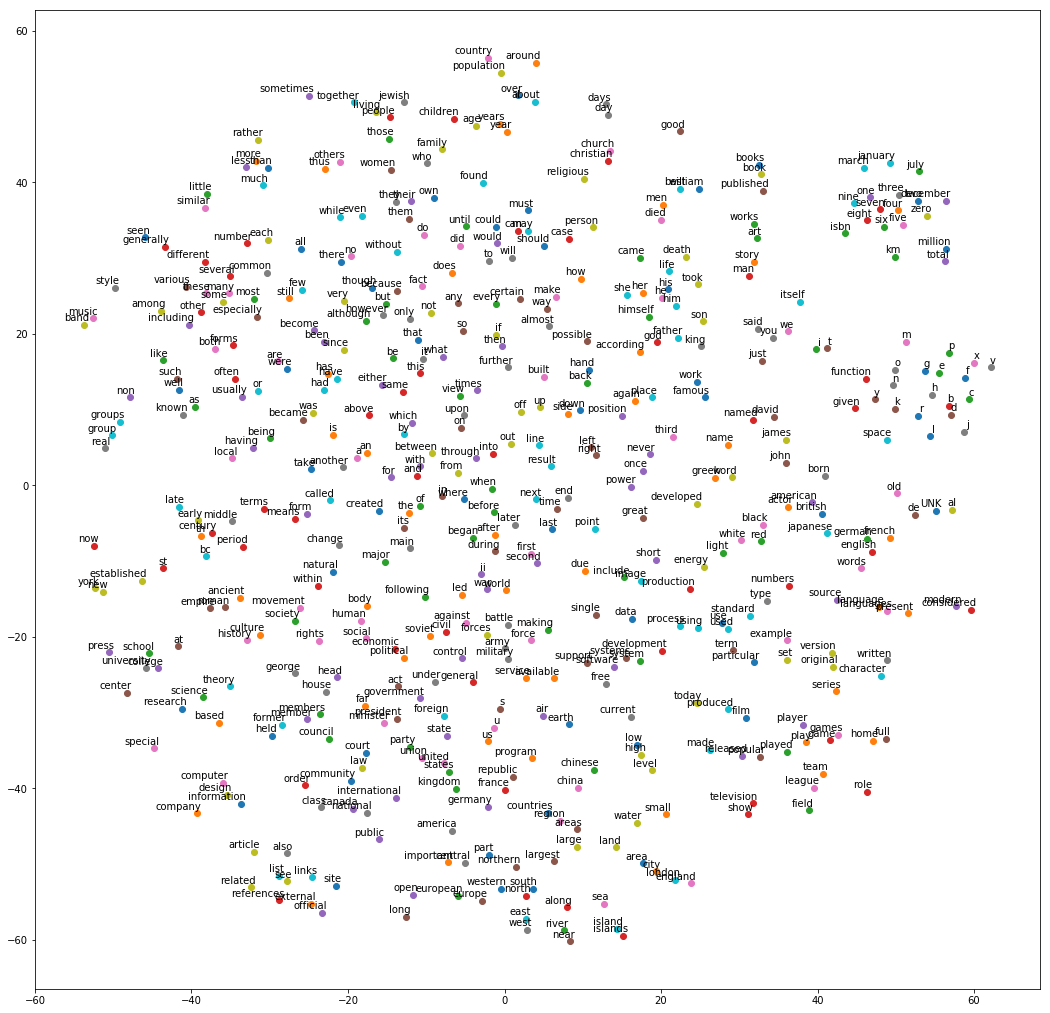

In [19]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)